In [1]:
import seaborn as sns, pandas as pd, numpy as np
from sklearn.svm import OneClassSVM, SVC
from pandas.plotting import parallel_coordinates
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, StratifiedKFold, ParameterGrid, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.lines as mlines
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy import stats

data = pd.read_csv('./results/features_df.csv')
data

,Corpus,Type,Avg Word Length,Avg Sentence Length,TTR,MATTR,Morpheme TTR,Avg Segs Per Word,Avg Forms Per Lemma,Char Dist Entr,Word Dist Entr,Text Entr,Lex Entr,Rev Lex Entr
0,vo,con,5.072,11.266,2.455,0.622,0.145,2.175,3.254,4.256,7.666,1.192,2.086,2.135
1,io,con,4.594,14.484,3.433,0.557,0.103,2.238,4.402,4.077,8.055,1.157,1.985,2.069
2,nl,nat,5.419,18.194,8.559,0.694,0.107,2.169,4.383,4.117,10.593,3.813,1.811,1.866
3,af,nat,5.067,20.496,6.987,0.645,0.124,2.098,3.941,4.072,9.993,4.088,1.839,1.914
4,tr,nat,6.630,14.458,14.097,0.828,0.090,2.023,5.573,4.386,13.151,4.114,1.562,1.656
5,eo,con,5.175,18.909,10.708,0.692,0.096,2.127,4.982,4.164,10.923,3.858,1.801,1.893
6,hu,nat,6.242,15.782,16.234,0.776,0.079,2.169,5.999,4.543,12.443,4.423,1.670,1.727
7,tl,nat,5.119,21.102,7.593,0.611,0.103,2.160,4.590,3.895,9.991,3.824,1.884,1.917
8,it,nat,5.455,25.727,8.505,0.764,0.088,2.152,5.352,4.029,11.308,4.003,1.672,1.786
9,sv,nat,5.597,17.322,11.031,0.756,0.091,2.217,5.028,4.294,11.488,4.170,1.775,1.836


One Class SVM

In [8]:
# X, y = data.iloc[:,2:].values.round(decimals=3), data.iloc[:,1].map({'con':-1, 'nat':1}).values
# scaler = StandardScaler()
# strat_kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
# svm = OneClassSVM()

# for train_idx, test_idx in strat_kfold.split(X, y):
#     X_train, X_test = X[train_idx], X[test_idx]
#     y_train, y_test = y[train_idx], y[test_idx]
    
#     # Extract 'nat' class for training
#     X_train_nat = X_train[y_train == 1]
    
#     # Normalize data
#     X_train_scaled = scaler.fit_transform(X_train_nat)
#     X_test_scaled = scaler.transform(X_test)
    
#     # Train
#     svm.fit(X_train_scaled)
    
#     # Predict
#     predictions = svm.predict(X_test_scaled)
    
#     # Evaluate
#     precision = precision_score(y_test, predictions, pos_label=-1)
#     recall = recall_score(y_test, predictions, pos_label=-1)
#     f1 = f1_score(y_test, predictions, pos_label=-1)
    
#     print(f"Precision: {precision}, Recall: {recall}, F1-score: {f1}")

In [9]:
# df = pd.read_csv('./results/features_df.csv')
# train_df = df.drop(df[df['Type'] == 'con'].index)
# test_df = df.drop(df[df['Type'] == 'nat'].index)

# scaler = StandardScaler()
# # Training on only natural languages
# X_train = scaler.fit_transform(train_df.iloc[:,2:].values.round(decimals=3))
# # Testing on constructed languages
# X_test = scaler.fit_transform(test_df.iloc[:,2:].values.round(decimals=3))

# # One-Class SVM Model
# # Do one for both: "in" class as conlangs and as natlangs
# svm = OneClassSVM(nu=0.01, kernel='rbf', gamma=0.00005, verbose=True)
# svm.fit(X_train)

# svm_pred = svm.predict(X_test)
# scores = svm.score_samples(X_test)
# print({lang: pred for lang, pred in zip(test_df['Corpus'], scores)})
# # print({lang: pred for lang, pred in zip(test_df['Corpus'], svm_pred)})

{'eo': 0.04120597173432923, 'lfn': 0.028173381272779647, 'ia': 0.04246367316493513, 'io': 0.03649438466435061}


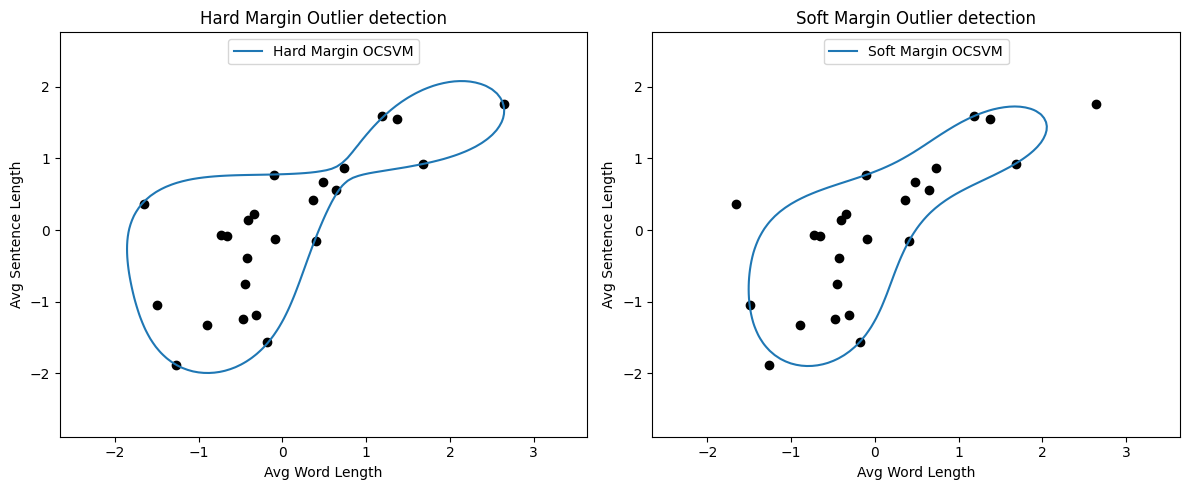

In [22]:
# EXAMPLE visualization using only 2 columns from the data: Avg Word Length and Avg Sentence Length

data = pd.read_csv('./results/features_df.csv')
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.iloc[:,2:].values.round(decimals=3))
X = scaled_data[:,[2,3]]

estimators_hard_margin = {
   "Hard Margin OCSVM": OneClassSVM(nu=0.01, gamma=0.35),  # Very small nu for hard margin
}
estimators_soft_margin = {
   "Soft Margin OCSVM": OneClassSVM(nu=0.25, gamma=0.35),  # Nu between 0 and 1 for soft margin
}

# Plotting setup
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
colors = ["tab:blue", "tab:orange", "tab:red"]
legend_lines = []

# Hard Margin OCSVM
ax = axs[0]
for color, (name, estimator) in zip(colors, estimators_hard_margin.items()):
   estimator.fit(X)
   DecisionBoundaryDisplay.from_estimator(
       estimator,
       X,
       response_method="decision_function",
       plot_method="contour",
       levels=[0],
       colors=color,
       ax=ax,
   )
   legend_lines.append(mlines.Line2D([], [], color=color, label=name))
ax.scatter(X[:, 0], X[:, 1], color="black")
ax.legend(handles=legend_lines, loc="upper center")
ax.set(
   xlabel="Avg Word Length",
   ylabel="Avg Sentence Length",
   title="Hard Margin Outlier detection",
)

# Soft Margin OCSVM
ax = axs[1]
legend_lines = []
for color, (name, estimator) in zip(colors, estimators_soft_margin.items()):
   estimator.fit(X)
   DecisionBoundaryDisplay.from_estimator(
       estimator,
       X,
       response_method="decision_function",
       plot_method="contour",
       levels=[0],
       colors=color,
       ax=ax,
   )
legend_lines.append(mlines.Line2D([], [], color=color, label=name))
ax.scatter(X[:, 0], X[:, 1], color="black")
ax.legend(handles=legend_lines, loc="upper center")
ax.set(
   xlabel="Avg Word Length",
   ylabel="Avg Sentence Length",
   title="Soft Margin Outlier detection",
)
plt.tight_layout()
plt.show()

In [18]:
# OneClassSVM without finetuning

features = data.drop(columns=['Corpus', 'Type'])
target = np.where(data['Type'] == 'nat', 1, -1)

scaler = StandardScaler()
# Train on target == 'nat' (natural languages)
X_train = scaler.fit_transform(features[target == 1])

# nu=0.25 means around 25% of my data are anomalies (6/24 languages are constructed)
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.25, verbose=True)
ocsvm.fit(X_train)

X_test = scaler.transform(features)
predictions = ocsvm.predict(X_test)
scores = ocsvm.score_samples(X_test)
print({lang: pred for lang, pred in zip(data['Corpus'], scores)})

predicted_types = np.where(predictions == 1, 'nat', 'con')
print({lang: pred for lang, pred in zip(data['Corpus'], predicted_types)})
# print(predictions)

# Model Performance report 

report = classification_report(data['Type'], predicted_types, target_names=['con', 'nat'], output_dict=True)
report.update({"accuracy": {"precision": None, "recall": None, "f1-score": report["accuracy"], "support": report['macro avg']['support']}})
ocsvm_without_finetuning_report = pd.DataFrame(report).transpose()
ocsvm_without_finetuning_report.to_csv('./results/ocsvm_without_finetuning_report.csv')

[LibSVM]*.*
optimization finished, #iter = 22
obj = 2.268433, rho = 1.008189
nSV = 11, nBSV = 0
{'vo': 0.013912462057527941, 'io': 0.020956766838592933, 'nl': 1.314671637548921, 'af': 1.008023048639672, 'tr': 1.0083839815994151, 'eo': 1.2653858225795784, 'hu': 1.0079313011397883, 'tl': 1.0082707375025826, 'it': 1.0079796576445919, 'sv': 1.15909895770196, 'is': 1.007975499443228, 'avk': 0.5120208624062906, 'da': 1.1705883098445993, 'es': 1.0081619230850136, 'lfn': 0.6477038676582259, 'en': 1.1139078983133266, 'fi': 1.0080985534972189, 'pl': 1.078837425906912, 'fr': 1.199498577773114, 'id': 1.0083839905655383, 'vi': 1.0081648101576777, 'oc': 1.0087011276906934, 'ia': 0.9848903546930443, 'de': 1.1079100499880834}
{'vo': 'con', 'io': 'con', 'nl': 'nat', 'af': 'con', 'tr': 'nat', 'eo': 'nat', 'hu': 'con', 'tl': 'nat', 'it': 'con', 'sv': 'nat', 'is': 'con', 'avk': 'con', 'da': 'nat', 'es': 'con', 'lfn': 'con', 'en': 'nat', 'fi': 'con', 'pl': 'nat', 'fr': 'nat', 'id': 'nat', 'vi': 'con', 'oc'

In [19]:
# OCSVM Finetuning
# Brute force approach (ParameterGrid)
# gamma defines how much influence a single training sample has. Smaller value means a larger radius of influence for each sample, and vice versa
# usually between γ∈[10^−6,10^0] used for the RBF kernel; common initial guesses around γ∈[0.001,1]
# nu is the upper bound on the fraction of training errors and a lower bound of support vectors. Controls proportion of outliers allowed
# usually between 0 and 1; common initial ranges around ν∈[0.01,0.5]

features = data.drop(columns=['Corpus', 'Type'])
target = np.where(data['Type'] == 'nat', 1, -1)

scaler = StandardScaler()
# Train on target == 'nat' (natural languages)
X_train = scaler.fit_transform(features[target == 1])
X_test = scaler.transform(features)

param_grid = {
    'gamma': [0.000001, 0.0001, 0.001, 0.01, 0.1, 1],
    'nu': [0.01, 0.05, 0.1, 0.25, 0.5]
}

grid = ParameterGrid(param_grid)
results = []
for params in grid:
    ocsvm = OneClassSVM(kernel='rbf', gamma=params['gamma'], nu=params['nu'])
    ocsvm.fit(X_train)
    predictions = ocsvm.predict(X_test)
    predicted_types = np.where(predictions == 1, 'nat', 'con')
    precision = precision_score(data['Type'], predicted_types, pos_label='con')
    recall = recall_score(data['Type'], predicted_types, pos_label='con')
    f1 = f1_score(data['Type'], predicted_types, pos_label='con')
    
    results.append({
        'gamma': params['gamma'],
        'nu': params['nu'],
        'precision': precision,
        'recall': recall,
        'f1': f1
    })
    
ocsvm_parameter_search_results_df = pd.DataFrame(results)
ocsvm_parameter_search_results_df.to_csv('./results/ocsvm_parameter_search_results_df.csv')
best_params = ocsvm_parameter_search_results_df.sort_values(by='f1', ascending=False).iloc[0]
print(f"Best Params: Gamma={best_params['gamma']}, Nu={best_params['nu']}")
print(best_params)

Best Params: Gamma=0.01, Nu=0.01
gamma        0.010000
nu           0.010000
precision    0.833333
recall       0.833333
f1           0.833333
Name: 15, dtype: float64


In [2]:
# OCSVM with Finetuned Hyperparams

features = data.drop(columns=['Corpus', 'Type'])
target = np.where(data['Type'] == 'nat', 1, -1)

scaler = StandardScaler()
# Train on target == 'nat' (natural languages)
X_train = scaler.fit_transform(features[target == 1])

best_ocsvm = OneClassSVM(kernel='rbf', gamma=0.01, nu=0.01, verbose=True)
best_ocsvm.fit(X_train)

X_test = scaler.transform(features)
predictions = best_ocsvm.predict(X_test)
scores = best_ocsvm.score_samples(X_test)
print({lang: pred for lang, pred in zip(data['Corpus'], scores)})

predicted_types = np.where(predictions == 1, 'nat', 'con')
print({lang: pred for lang, pred in zip(data['Corpus'], predicted_types)})
# print(predictions)

# Model performance report 
report = classification_report(data['Type'], predicted_types, target_names=['con', 'nat'], output_dict=True)
report.update({"accuracy": {"precision": None, "recall": None, "f1-score": report["accuracy"], "support": report['macro avg']['support']}})
ocsvm_with_finetuning_report = pd.DataFrame(report).transpose()
ocsvm_with_finetuning_report.to_csv('./results/ocsvm_with_finetuning_report.csv')

[LibSVM]*
optimization finished, #iter = 8
obj = 0.009500, rho = 0.105389
nSV = 3, nBSV = 0
{'vo': 0.05588638329508355, 'io': 0.052511772499456905, 'nl': 0.11459314369604506, 'af': 0.11114813363913367, 'tr': 0.10722318654091989, 'eo': 0.11542165747017506, 'hu': 0.10856908219151015, 'tl': 0.10486448503055204, 'it': 0.10955339005192108, 'sv': 0.1144237614411577, 'is': 0.1111022174187162, 'avk': 0.09531066252449534, 'da': 0.1153832105571588, 'es': 0.1096249534911198, 'lfn': 0.10094554197111438, 'en': 0.11663304564903434, 'fi': 0.10565111631130251, 'pl': 0.11219358166639931, 'fr': 0.11405525152151759, 'id': 0.10706181840471977, 'vi': 0.10565111540273145, 'oc': 0.10930978591017067, 'ia': 0.10418749251936446, 'de': 0.11326071226451283}
{'vo': 'con', 'io': 'con', 'nl': 'nat', 'af': 'nat', 'tr': 'nat', 'eo': 'nat', 'hu': 'nat', 'tl': 'con', 'it': 'nat', 'sv': 'nat', 'is': 'nat', 'avk': 'con', 'da': 'nat', 'es': 'nat', 'lfn': 'con', 'en': 'nat', 'fi': 'nat', 'pl': 'nat', 'fr': 'nat', 'id': 'nat

One-Class SVM Visualization (Decision Boundary)

In [21]:
# # Plot decision function values
# # Maybe try following https://stackoverflow.com/questions/66186272/how-to-plot-the-decision-boundary-of-a-one-class-svm for better visualization
# plt.figure(figsize=(10, 6))
# plt.scatter(np.arange(len(scores)), scores, marker='o', s=50)
# plt.xlabel('Language Index')
# plt.ylabel('Decision Function Value')
# plt.title('Distance to Decision Boundary')
# plt.xticks(np.arange(len(scores)), test_df['Corpus'], rotation=45, ha='right')  # Use language names as x-axis`` labels
# plt.grid(True)
# plt.show()

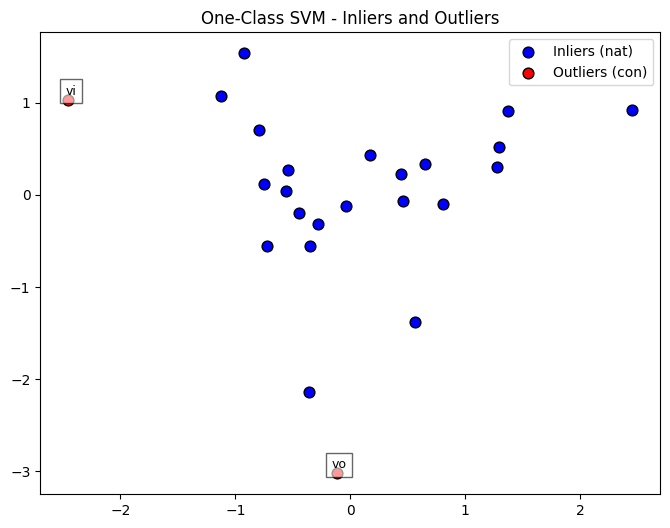

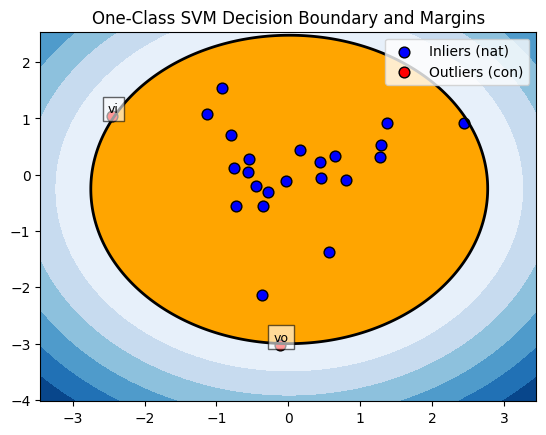

In [3]:
# Plot decision function of finetuned One-Class SVM (visualization in 2D space)
# How can I interpret the decision function? Should I visualize the decision boundary differently?

features = data.drop(columns=['Corpus', 'Type'])
target = np.where(data['Type'] == 'nat', 1, -1)
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_2d)
best_ocsvm = OneClassSVM(kernel='rbf', gamma=0.01, nu=0.01)
best_ocsvm.fit(features_scaled)

# Predict the decision function (distance to the decision boundary)
decision_function = best_ocsvm.decision_function(features_scaled)
predictions = best_ocsvm.predict(features_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(features_scaled[predictions == 1][:, 0], features_scaled[predictions == 1][:, 1], 
            c='blue', label='Inliers (nat)', edgecolors='k', s=60)
plt.scatter(features_scaled[predictions == -1][:, 0], features_scaled[predictions == -1][:, 1], 
            c='red', label='Outliers (con)', edgecolors='k', s=60)

corpus = data['Corpus'].values

# Annotate the outliers with their corresponding 'Corpus' values
for i, corpus_value in enumerate(corpus):
    if predictions[i] == -1: 
        plt.text(features_scaled[i, 0] + 0.02, features_scaled[i, 1] + 0.02, corpus_value,
                 fontsize=9, color='black', ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.6))

plt.title('One-Class SVM - Inliers and Outliers')
plt.legend()
plt.show()

# Plot decision boundary and margins
xx, yy = np.meshgrid(np.linspace(features_scaled[:, 0].min() - 1, features_scaled[:, 0].max() + 1, 500),
                     np.linspace(features_scaled[:, 1].min() - 1, features_scaled[:, 1].max() + 1, 500))

Z = best_ocsvm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision function as a contour plot
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='orange')

plt.scatter(features_scaled[predictions == 1][:, 0], features_scaled[predictions == 1][:, 1], 
            c='blue', label='Inliers (nat)', edgecolors='k', s=60)
plt.scatter(features_scaled[predictions == -1][:, 0], features_scaled[predictions == -1][:, 1], 
            c='red', label='Outliers (con)', edgecolors='k', s=60)

# Annotate the outliers with their corresponding 'Corpus' values
for i, corpus_value in enumerate(corpus):
    if predictions[i] == -1: 
        plt.text(features_scaled[i, 0] + 0.02, features_scaled[i, 1] + 0.02, corpus_value,
                 fontsize=9, color='black', ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.6))

plt.title('One-Class SVM Decision Boundary and Margins')
plt.legend()
plt.show()

<Figure size 800x600 with 0 Axes>

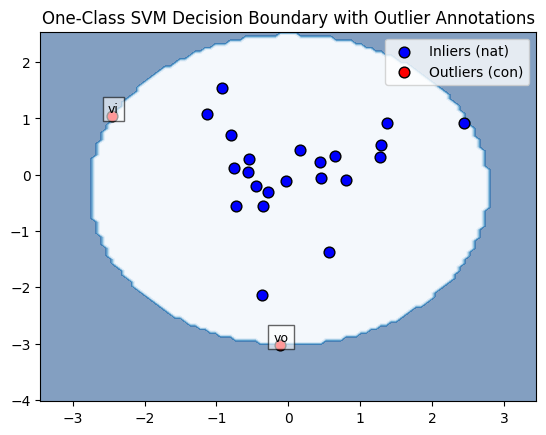

In [4]:
features = data.drop(columns=['Corpus', 'Type'])
target = np.where(data['Type'] == 'nat', 1, -1)
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_2d)

best_ocsvm = OneClassSVM(kernel='rbf', gamma=0.01, nu=0.01)
best_ocsvm.fit(features_scaled)

predictions = best_ocsvm.predict(features_scaled)

plt.figure(figsize=(8, 6))

DecisionBoundaryDisplay.from_estimator(best_ocsvm, features_scaled, response_method="predict",
                                       cmap=plt.cm.Blues_r, alpha=0.5)

plt.scatter(features_scaled[predictions == 1][:, 0], features_scaled[predictions == 1][:, 1], 
            c='blue', label='Inliers (nat)', edgecolors='k', s=60)
plt.scatter(features_scaled[predictions == -1][:, 0], features_scaled[predictions == -1][:, 1], 
            c='red', label='Outliers (con)', edgecolors='k', s=60)

for i, corpus_value in enumerate(corpus):
    if predictions[i] == -1:  
        plt.text(features_scaled[i, 0] + 0.02, features_scaled[i, 1] + 0.02, corpus_value,
                 fontsize=9, color='black', ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.6))

plt.title('One-Class SVM Decision Boundary with Outlier Annotations')
plt.legend()
plt.show()

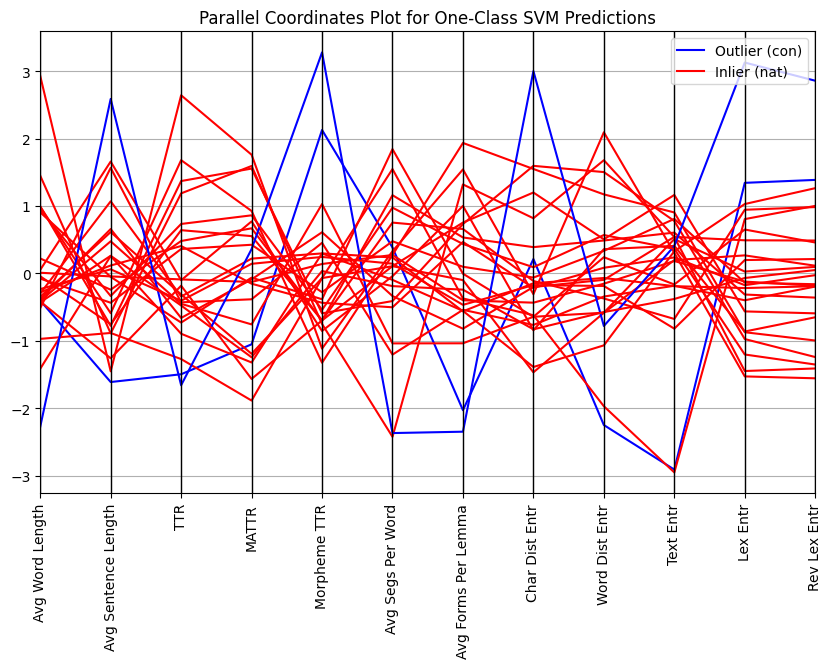

In [6]:
features = data.drop(columns=['Corpus', 'Type'])
target = np.where(data['Type'] == 'nat', 1, -1)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_df = pd.DataFrame(features_scaled, columns=['Avg Word Length', 'Avg Sentence Length', 'TTR', 'MATTR', 'Morpheme TTR', 'Avg Segs Per Word', 'Avg Forms Per Lemma', 'Char Dist Entr', 'Word Dist Entr', 'Text Entr', 'Lex Entr', 'Rev Lex Entr'])
features_df['Prediction'] = predictions

# Replace 1 with 'Inlier (nat)' and -1 with 'Outlier (con)' for readability
features_df['Prediction'] = features_df['Prediction'].replace({1: 'Inlier (nat)', -1: 'Outlier (con)'})

plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
parallel_coordinates(features_df, 'Prediction', color=['blue', 'red'])
plt.title('Parallel Coordinates Plot for One-Class SVM Predictions')
plt.savefig('./results/parallelcoordinatesplotocsvm.png')
plt.show()

Local Outlier Factor

In [ ]:
# lof = LocalOutlierFactor(n_neighbors=18, algorithm='auto', novelty=True, contamination=0.1)
# lof.fit(X_train)

# lof_pred = lof.predict(X_test)
# print({lang: pred for lang, pred in zip(test_df['corpus'], lof_pred)})

Decision Tree

Fitting 24 folds for each of 144 candidates, totalling 3456 fits


/usr/local/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters:  {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


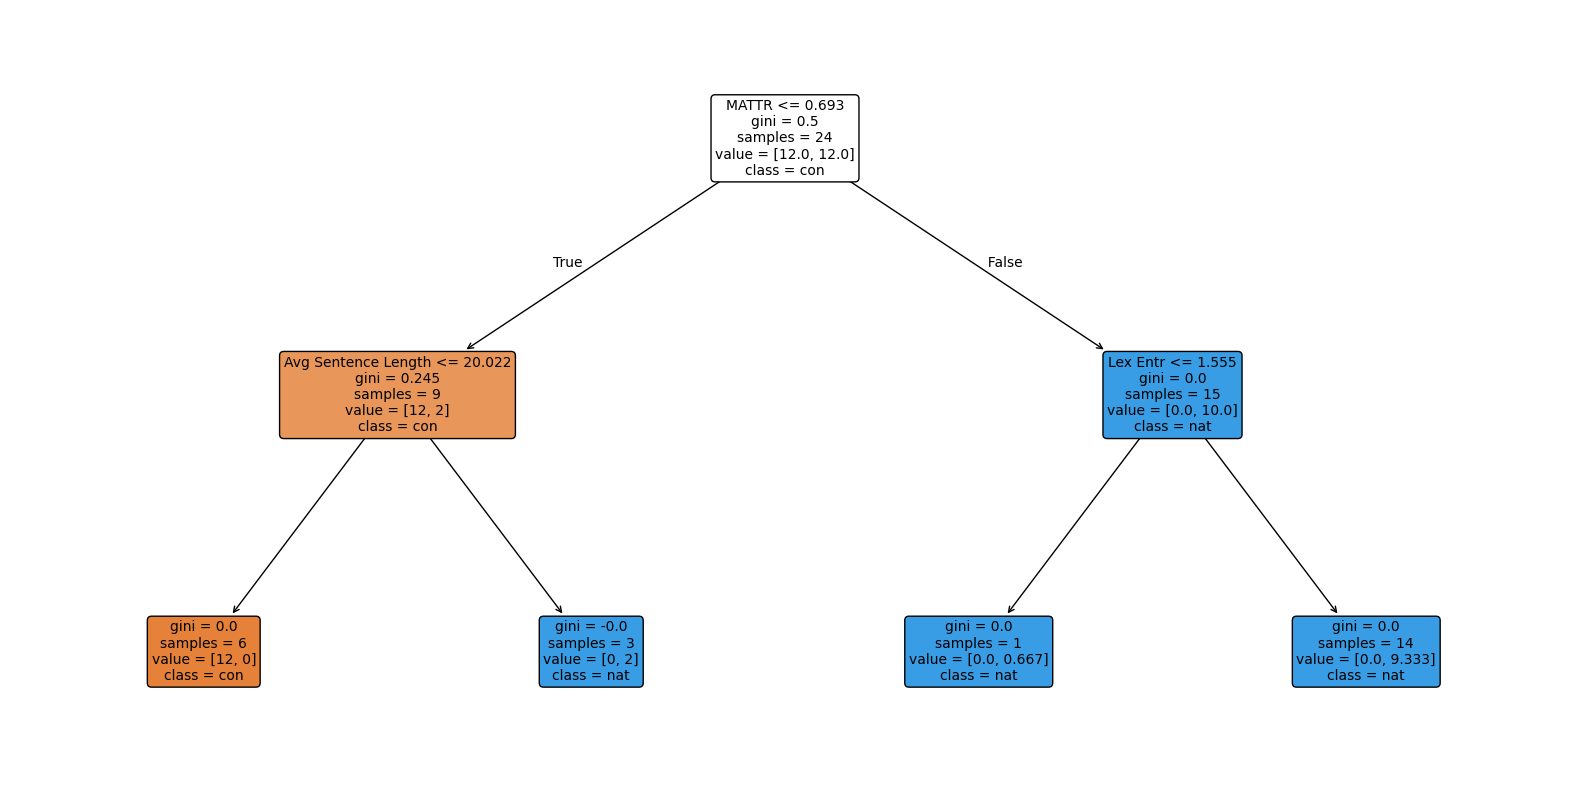

In [25]:
X, y = data.iloc[:,2:].values.round(decimals=3), data.iloc[:,1].map({'con':0, 'nat':1}).values

param_grid = {
    'criterion':  ['gini', 'entropy'],
    'max_depth':  [None, 2, 4, 6, 8, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Try using F1 score (due to inbalanced data)
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(class_weight='balanced', random_state=42),
    param_grid=param_grid,
    cv=KFold(n_splits=len(X), shuffle=True, random_state=42),
    scoring='accuracy',
    verbose=1,
)

grid_search.fit(X, y)
print("Best parameters: ", grid_search.best_params_)

# Best estimator fitted with best parameters
best_tree = grid_search.best_estimator_

plt.figure(figsize=(20, 10))
tree.plot_tree(best_tree, filled=True, feature_names=['Avg Word Length', 'Avg Sentence Length', 'TTR', 'MATTR', 'Morpheme TTR',	'Avg Segs Per Word', 'Avg Forms Per Lemma', 'Char Entr', 'Word Entr', 'Text Entr', 'Lex Entr', 'Rev Lex Entr'], class_names=['con', 'nat'], rounded=True, fontsize=10)
plt.savefig('./results/decisiontree.png')
plt.show()

Leave One Out

In [ ]:
# loo = LeaveOneOut()
# cross_val_scores = cross_val_score(clf, X, y, cv=kfold)

# predictions = clf.predict(X)
# print(accuracy_score(y, predictions))

# print("Cross-validation scores: ", cross_val_scores)
# print("Mean accuracy: ", cross_val_scores.mean())

Random Forest

In [26]:
# Random Forest Without Finetuning

X, y = data.iloc[:,2:].values.round(decimals=3), data.iloc[:,1].map({'con':0, 'nat':1}).values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['con', 'nat'])
print(report)

              precision    recall  f1-score   support

         con       1.00      1.00      1.00         1
         nat       1.00      1.00      1.00         4

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



Feature Importances: [0.10854812 0.06256885 0.10771493 0.1663299  0.03567732 0.03848323
 0.03695788 0.05812822 0.13061251 0.10201136 0.07498413 0.07798355]


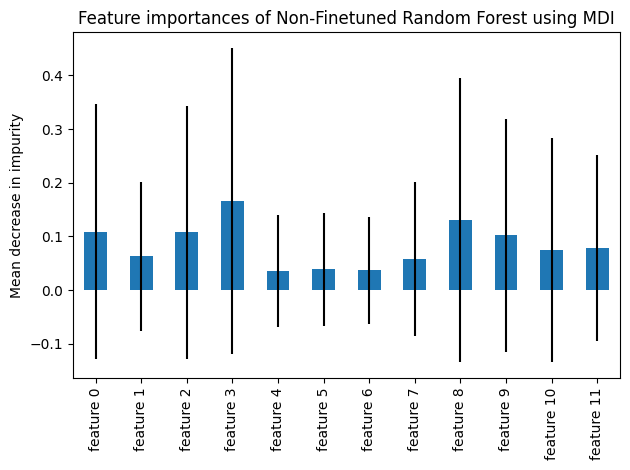

In [27]:
# Plotting Feature Importances of Non-Finetuned RandomForest
# Refer to https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

# Get feature importance
importances = rf.feature_importances_
print("Feature Importances:", importances)

feature_names = [f"feature {i}" for i in range(X.shape[1])]
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances of Non-Finetuned Random Forest using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [28]:
y_prob = rf.predict_proba(X_test)

# Probability of being 'con' or 'nat'
con_probabilities = y_prob[:, 0]

# Flag potential outliers based on low probability (< 0.3 confidence for 'con')
outliers = con_probabilities < 0.3
print("Potential outliers:", X_test[outliers])

Potential outliers: [[ 5.597 17.322 11.031  0.756  0.091  2.217  5.028  4.294 11.488  4.17
   1.775  1.836]
 [ 5.087 21.301  6.079  0.697  0.116  2.136  4.091  4.167 10.673  4.116
   1.926  1.981]
 [ 5.375 15.055 11.727  0.747  0.091  2.16   5.181  4.468 11.512  4.643
   1.728  1.796]
 [ 5.215 18.66   7.185  0.715  0.109  2.162  4.336  4.173 10.546  2.963
   1.871  1.934]]


In [29]:
# Random Forest With Finetuning (Best RF)

X, y = data.iloc[:,2:].values.round(decimals=3), data.iloc[:,1].map({'con':0, 'nat':1}).values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_rf = RandomForestClassifier(**best_params)
best_rf.fit(X_train, y_train)

Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


RandomForestClassifier(min_samples_leaf=2)

In [30]:
#  Measuring Finetuned Random Forest's Performance

y_pred = best_rf.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['con', 'nat'])
print(report)

              precision    recall  f1-score   support

         con       1.00      1.00      1.00         1
         nat       1.00      1.00      1.00         4

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



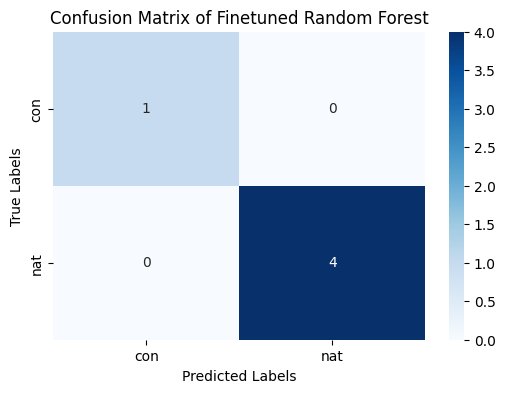

In [31]:
# Confusion Matrix for Finetuned Random Forest's Performance

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['con', 'nat'], yticklabels=['con', 'nat'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of Finetuned Random Forest')
plt.show()

Feature Importances: [0.06999198 0.04519591 0.08863434 0.1844     0.02404321 0.02785969
 0.02327011 0.02967821 0.12332104 0.10285366 0.08657855 0.19417329]


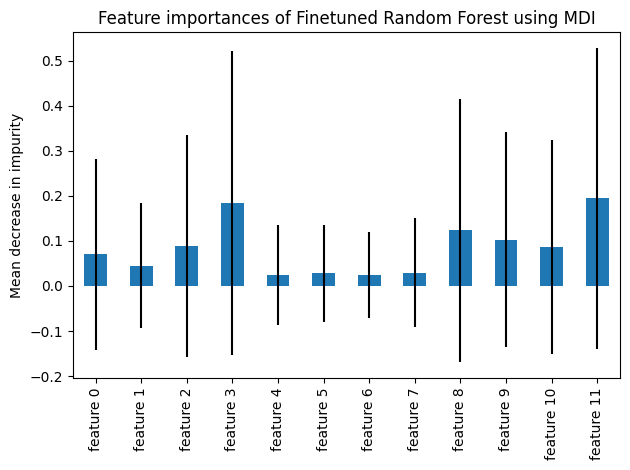

In [32]:
# Plotting Feature Importances of Finetuned RandomForest
# Refer to https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

# Get feature importance
importances = best_rf.feature_importances_
print("Feature Importances:", importances)

feature_names = [f"feature {i}" for i in range(X.shape[1])]
std = np.std([tree.feature_importances_ for tree in best_rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances of Finetuned Random Forest using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Isolation Forest

In [23]:
# Isolation Forest without Finetuning

X, y = data.iloc[:,2:].values.round(decimals=3), data.iloc[:,1].map({'con':0, 'nat':1}).values
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

clf = IsolationForest(contamination=0.1, random_state=42)
clf.fit(X)

predictions = clf.predict(X)
predicted_types = ['con' if p == -1 else 'nat' for p in predictions]

print(confusion_matrix(y, predicted_types))
print(classification_report(y, predicted_types, target_names=['con', 'nat']))

[[ 1  5]
 [ 2 16]]
              precision    recall  f1-score   support

         con       0.33      0.17      0.22         6
         nat       0.76      0.89      0.82        18

    accuracy                           0.71        24
   macro avg       0.55      0.53      0.52        24
weighted avg       0.65      0.71      0.67        24



Binary Classification (SVM)

In [7]:
# With linear kernel

X, y = data.iloc[:,2:].values.round(decimals=3), data.iloc[:,1].map({'con':0, 'nat':1}).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1],
    'gamma': ['scale', 'auto', 0.01, 0.1],
    # 'class_weight': ['balanced', {0: 1, 1: 3}, {0: 1, 1: 4}]
    'class_weight': ['balanced']
}

svc = SVC(kernel='linear', random_state=42)
skf = StratifiedKFold(n_splits=12, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='f1', cv=skf, verbose=1)

grid_search.fit(X_train_scaled, y_train)
print("Best parameters found by grid search:", grid_search.best_params_)

best_svc = grid_search.best_estimator_
y_pred = best_svc.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=['con', 'nat'])

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Fitting 12 folds for each of 16 candidates, totalling 192 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=12.
  warnings.warn(


Best parameters found by grid search: {'C': 0.0001, 'class_weight': 'balanced', 'gamma': 'scale'}
Accuracy: 0.60
Confusion Matrix:
 [[1 0]
 [2 2]]
Classification Report:
               precision    recall  f1-score   support

         con       0.33      1.00      0.50         1
         nat       1.00      0.50      0.67         4

    accuracy                           0.60         5
   macro avg       0.67      0.75      0.58         5
weighted avg       0.87      0.60      0.63         5



In [ ]:
# # Preprocess
# data = preprocess_text(corpora, classification='binary')
# text, labels = [d[0] for d in data], [d[1] for d in data]
# vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(1,2))
# vectorizer.fit(text)
# text = vectorizer.transform(text)

# # Split 
# X_train, X_test, y_train, y_test = train_test_split(text, labels, test_size=0.2, random_state=42, shuffle=True)

# # Model
# clf = SGDClassifier(loss="log_loss", tol=1e-3, verbose=0, random_state=42, validation_fraction=0.1)
# batch_size = 10000
# num_batches = X_train.shape[0] // batch_size

# # Training
# for i in range(num_batches):
#     start = i * batch_size
#     end = min((i + 1) * batch_size, X_train.shape[0])
#     batch_x, batch_y = X_train[start:end], y_train[start:end]
#     clf.fit(batch_x, batch_y)
    
# # Plot
# y_pred = clf.predict(X_test)
# cm = confusion_matrix(y_test, y_pred)

# fig, ax = plt.subplots(figsize=(8, 8))
# sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='g', ax=ax)
# ax.set_xlabel('Predicted Labels')
# ax.set_ylabel('Actual Labels')
# ax.set_title('Confusion Matrix')
# plt.show()

# # Metrics
# accuracy = clf.score(X_test, y_test)
# print(f'Accuracy: {accuracy}')

Multi-Classification (SVM)

In [ ]:
# # Preprocess
# # functions from char_freq.ipynb
# data = preprocess_text(corpora, sequences=100000, classification='multi')
# text, labels = [d[0] for d in data], [d[1] for d in data]
# vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(2,2))
# vectorizer.fit(text)
# text = vectorizer.transform(text)

# # Split 
# X_train, X_test, y_train, y_test = train_test_split(text, labels, test_size=0.2, random_state=42, shuffle=True)

# # Model
# clf = SGDClassifier(loss="log_loss", tol=1e-3, verbose=0, random_state=42, validation_fraction=0.1)
# batch_size = 10000
# num_batches = X_train.shape[0] // batch_size

# # Training
# for i in range(num_batches):
#     start = i * batch_size
#     end = min((i + 1) * batch_size, X_train.shape[0])
#     batch_x, batch_y = X_train[start:end], y_train[start:end]
#     clf.fit(batch_x, batch_y)
    
# # Plot
# y_pred = clf.predict(X_test)
# cm = confusion_matrix(y_test, y_pred)

# fig, ax = plt.subplots(figsize=(8, 8))
# sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='g', ax=ax)
# ax.set_xlabel('Predicted Labels')
# ax.set_ylabel('Actual Labels')
# ax.set_title('Confusion Matrix')
# plt.show()

# # Metrics
# accuracy = clf.score(X_test, y_test)
# print(f'Accuracy: {accuracy}')

Multi-Classification (RNN)

In [ ]:
# # Preprocess
# data = preprocess_text(corpora, sequences=200000, classification='multi')
# text, labels = [d[0] for d in data], [d[1] for d in data]
# vectorizer = CountVectorizer(analyzer='char')
# vectorizer.fit(text)
# text = vectorizer.transform(text)

# # Split 
# X_train, X_test, y_train, y_test = train_test_split(text, labels, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
# avgs = []
# for corpus in corpora:
#     with open(corpus, 'r', encoding='utf-8') as f:
#         text = f.read().splitlines()
#         f.close()
#     longest = len(max(text))
#     avg = sum(map(len, text)) / len(text)
#     avgs.append(avg)
#     print(f'{corpus}: Longest sequence is {longest} char, average is {int(avg)} char.')
    
# print(f'Avg length is {int(sum(avgs) / len(avgs))}')